In [1]:
pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/f0/89/b1ae45689abecca777f95462781a76e67ff46b55495a481ec5a73a739994/Cython-3.0.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for statsmodels>=0.13.2 from https://files.pythonhosted.org/packages/9f/06/2f1d2ba024c802e812fe9e85eebc06871d76f1f4e0bb2beb0faa22cbe330/statsmodels-0.14.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for patsy>=0.5.6 from https://files.pythonhosted.org/packages/43/f3/1d311a09c34f14f5973bb0bb0dc3a6e007e1eda90b5492d082689936ca51/patsy-0.5.6-py2.py3-none-any.whl.metadata
   ━━

In [4]:
import pandas as pd
from pmdarima import auto_arima
import os

In [53]:
# 파일 호출
data_path: str = "/data/ephemeral/home/BTC/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD.csv"))
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
tra_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # test 에는 _type = test


In [24]:
vdf=train_df[["datetime","close"]]

In [50]:
# 문자열을 datetime 형식으로 변환
vdf['datetime'] = pd.to_datetime(vdf['datetime'])

# 변환된 데이터 타입 확인
print(vdf['datetime'].dtypes)

datetime64[ns]


/tmp/ipykernel_127743/2899253180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdf['datetime'] = pd.to_datetime(vdf['datetime'])


In [48]:
vdf["datetime"].dtype

dtype('O')

In [40]:
import matplotlib.pyplot as plt

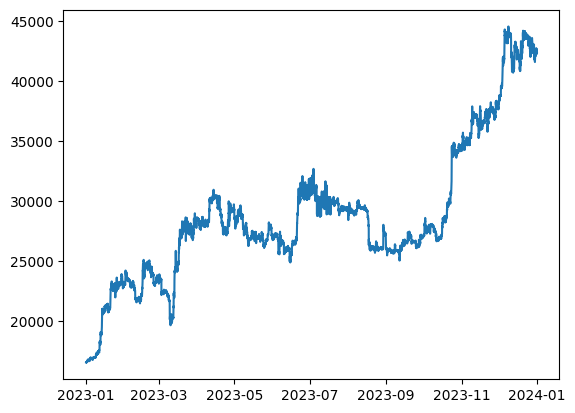

In [51]:
plt.plot(vdf["datetime"],vdf["close"])
plt.show()

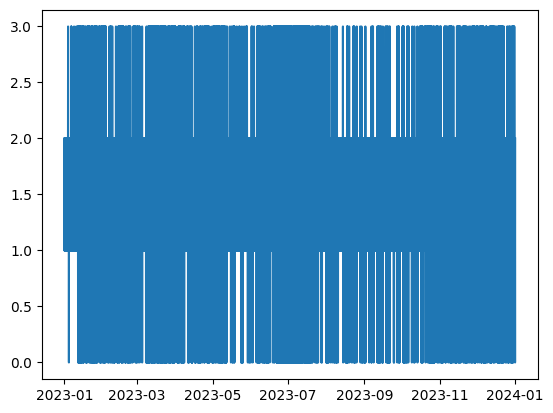

In [55]:
plt.plot(vdf["datetime"],tra_df["target"])
plt.show()

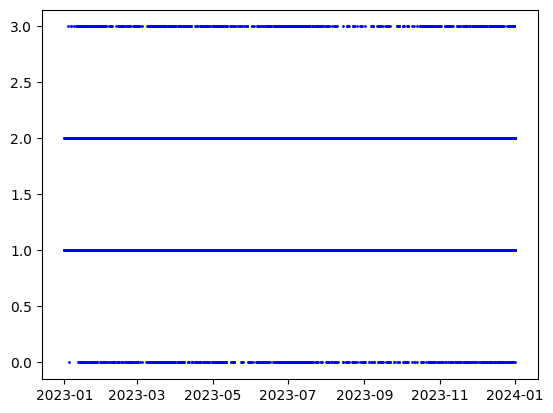

In [63]:
plt.scatter(vdf["datetime"], tra_df["target"],s=1,c='blue')
plt.show()

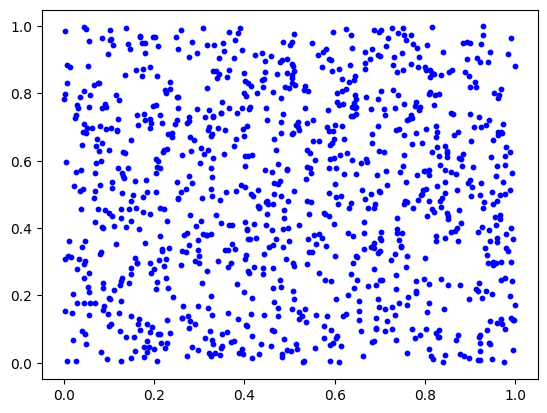

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# 랜덤한 점 1000개 생성
x = np.random.rand(1000)
y = np.random.rand(1000)

# 점 그리기
plt.scatter(x, y, s=1, c='blue')  # s는 점의 크기, c는 색상
plt.show()

In [25]:
import torch



# PyTorch
print(torch.cuda.is_available())

True


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
# AutoARIMA 모델 생성 및 적합
model = auto_arima(vdf['close'], start_p=1, start_q=1,
                  max_p=3, max_q=3,
                  start_P=1, start_Q=1, max_P=2, max_Q=2, seasonal=True,
                  trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=115733.538, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=116464.273, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=115731.639, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=115779.976, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=116464.446, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=115733.551, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=115730.276, Time=3.82 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=115725.335, Time=2.57 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=115732.073, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=115725.865, Time=4.91 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=115726.135, Time=3.67 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=115727.927, Time=1.16 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 18.573 seconds


In [35]:
len(test_df)

2792

In [36]:
forecast = model.predict(n_periods=len(test_df)+1)

In [37]:
forecast

8760     42285.475246
8761     42299.213038
8762     42304.860555
8763     42310.887077
8764     42315.163594
             ...     
11548    50536.323004
11549    50539.275180
11550    50542.227356
11551    50545.179532
11552    50548.131708
Length: 2793, dtype: float64

In [39]:
# 백분율 변화율 계산
percent_change = (forecast - forecast.shift(1)) / forecast.shift(1) * 100

# 첫 번째 값은 NaN이므로 제거 (선택 사항)
percent_change = percent_change.dropna()

#print(percent_change)
len(percent_change)

2792